We will now attempt doing something more elaborate than predicting the most commonly purchased items, though arguably this will still be very simple.

That is good though! We want to develop our solution piece by piece and we need to start somewhere.

In this notebook we will attempt learning embeddings for each user and each product and calculating a score that ideally will reflect if there is a match.

We will then use this score to order our predictions.

Let's get started.

In [1]:
%%time

%run utils.py

CPU times: user 25.2 s, sys: 8.35 s, total: 33.6 s
Wall time: 35.9 s


In [62]:
transactions.shape[0]

31788324

In [63]:
customers.shape[0]

1371980

<AxesSubplot:>

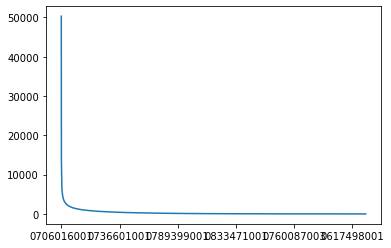

In [71]:
transactions.article_id.value_counts().plot()

<AxesSubplot:>

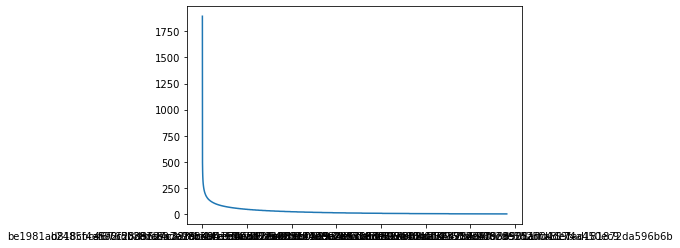

In [73]:
transactions['customer_id'].value_counts().plot()

In [74]:
transactions['customer_id'].value_counts().describe()

count    1.362281e+06
mean     2.333463e+01
std      3.924225e+01
min      1.000000e+00
25%      3.000000e+00
50%      9.000000e+00
75%      2.700000e+01
max      1.895000e+03
Name: customer_id, dtype: float64

There is a lot of data, over 30 mln transction records and over 1 mln customer records.

As expected, there is a small portion of customers who buy a lot, and similarily there is a small subset of articles that are purchased frequently.

We will exploit this fact to train a small model.

In [2]:
import torch
from torch import nn

In [3]:
art_ids = transactions.article_id.unique()
art_id2idx = {art_id: idx for idx, art_id in enumerate(art_ids)}

cust_ids = customers.customer_id.unique()
cust_id2idx = {cust_id: idx for idx, cust_id in enumerate(cust_ids)}

In [4]:
vc = transactions_without_last_7_days.customer_id.value_counts()
(vc.values > 200).sum()

11074

In [5]:
frequent_buyers = set((vc[vc > 200]).index)

In [6]:
transactions_without_last_7_days.loc[transactions_without_last_7_days.customer_id.isin(frequent_buyers), 'article_id'].nunique()

86744

In [9]:
sample_sub.customer_id.isin(frequent_buyers).mean()

0.04040000583098879

That's only 4% of the customers that make up  the submission, but chances are that their purchases are disproportionately important (they are much more likely to make a purchase in the test set period than the remaining customers).

Besides, if this approach works, we might attempt to scale it to other customers as well. Still, the objective here is to get a feel for what goes into training a recommender model (or better yet, creating a recommender system), which -- combined with reading research papers and the Kaggle forum -- can inform our subsequent iterations.

In [9]:
transactions_min = transactions_without_last_7_days.loc[transactions_without_last_7_days.customer_id.isin(frequent_buyers)]
transactions_min.reset_index(inplace=True, drop=True)

idxs = transactions_min.index.tolist()

In [10]:
np.random.shuffle(idxs)

In [11]:
len(idxs)

3182664

Over 3 mln transactions in our train set! Let's create a validation set.

In [12]:
train_idxs = idxs[:int(0.9*len(idxs))]
valid_idxs = idxs[int(0.9*len(idxs)):]

# pd.to_pickle(train_idxs, 'data/train_idxs.pkl')
# pd.to_pickle(valid_idxs, 'data/valid_idxs.pkl')

Below we construct a `Dataset` that will present our model with pairs of ids (`customer_id` and a `product_id`). If the pair represents a transaction, the target will be `1`. If the pair doesn't represent a transaction, the target will be `0`.

This should hopefully allow our model to learn meaningful embeddings.

In [14]:
class Dataset():
    def __init__(self, idxs, transactions_df=transactions_min):
        self.idxs = idxs
        self.transactions_df = transactions_df
    def __getitem__(self, idx):
        if idx < len(self)/2:
            idx_into_transactions_df = self.idxs[idx]
            cust_id = cust_id2idx[self.transactions_df.iloc[idx_into_transactions_df]['customer_id']]
            art_id = art_id2idx[self.transactions_df.iloc[idx_into_transactions_df]['article_id']]
            return [cust_id, art_id], np.array([1]).astype(np.float32)
        else:
            idx -= len(self)
            idx_into_transactions_df = self.idxs[idx]
            cust_id = cust_id2idx[self.transactions_df.iloc[idx_into_transactions_df]['customer_id']]
            art_id = art_id2idx[self.transactions_df.iloc[np.random.randint(len(self)/2)]['article_id']]
            return [cust_id, art_id], np.array([0]).astype(np.float32)
    def __len__(self):
        return 2*len(self.idxs)

In [15]:
# code I didn't end up using but keeping it here -- this samples epochs of arbitrary length, can be useful with
# this amount of data, maybe I'll use it down the road

# from torch.utils.data import SubsetRandomSampler, Sampler

# # https://discuss.pytorch.org/t/new-subset-every-epoch/85018

# class RandomSampler(Sampler):
#     def __init__(self, data_source, samples_per_epoch=None):
#         self.data_source = data_source
#         self._num_samples = samples_per_epoch

#     @property
#     def num_samples(self):
#         # dataset size might change at runtime
#         if self._num_samples is None:
#             return len(self.data_source)
#         return self._num_samples

#     def __iter__(self):
#         n = len(self.data_source)
#         return iter(torch.randperm(n, dtype=torch.int64)[:self.num_samples].tolist())

#     def __len__(self):
#         return self.num_samples

In [16]:
train_ds = Dataset(train_idxs)
valid_ds = Dataset(valid_idxs)

In [17]:
from fastai import *
from fastai.learner import Learner
from fastai.data.core import DataLoaders

from fastai.callback.all import *
from fastprogress import fastprogress

from fastai.metrics import *

from torch.utils.data import DataLoader

In [18]:
bs = 1024

train_dl = DataLoader(
    train_ds,
    batch_size=bs,
    num_workers=24,
    shuffle=True
#     sampler=RandomSampler(train_ds, samples_per_epoch=1_000_000) 
)

valid_dl = DataLoader(
    valid_ds,
    batch_size=bs,
    num_workers=24,
#     sampler=RandomSampler(valid_ds, samples_per_epoch=1_000)
)

In [21]:
# the commented out code allows you to experiment with different sizes of the classifier head
# also, you might want to try the dot product formulation in the `forward` method and see what
# results you can get with something like https://github.com/spotify/annoy

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.cust_embed = nn.Embedding(len(cust_ids), 128)
        self.art_embed = nn.Embedding(len(art_ids), 128)
        self.classifier = nn.Sequential(*[
#             nn.Linear(128, 128), nn.ReLU(), nn.BatchNorm1d(128),
            nn.Linear(256, 128), nn.ReLU(),
#             nn.Linear(128, 128), nn.ReLU(), nn.Dropout(p=0.1), nn.BatchNorm1d(128),
            nn.Linear(128, 1)
        ])
    
    def forward(self, x):
        c = self.cust_embed(x[0])
        a = self.art_embed(x[1])
#         return (c * a).sum(axis=-1).reshape(-1,1)
        ca = torch.cat([c, a], dim=1)
        
        return self.classifier(ca)

In [19]:
def accuracy(preds, targs):
    return ((preds > 0) == targs).float().mean().item()

In [22]:
learn = Learner(
    DataLoaders(train_dl, valid_dl),
    Model(),
    loss_func=torch.nn.BCEWithLogitsLoss(),
    metrics=[accuracy]
)

In [38]:
learn.fit(30, lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.693313,0.693277,0.501885,04:11
1,0.693127,0.692812,0.508801,04:12
2,0.692301,0.692019,0.515655,04:12
3,0.691326,0.689241,0.523892,04:12
4,0.687591,0.685974,0.529269,04:09
5,0.685432,0.681903,0.535205,43:45
6,0.682422,0.678360,0.544002,04:16
7,0.680124,0.675503,0.548993,04:14
8,0.677659,0.673049,0.554792,04:13
9,0.674002,0.670446,0.558460,04:13


In [39]:
# learn.save('basic_model')

Path('models/basic_model.pth')

In [23]:
learn.load('basic_model')

Now that we have a trained model, we need to somehow go from it to predictions for each article for each customer.

With just 11074 customers and 86744 articles and as simple a model as we have that will not pose too big of an issue. But with more data that could certainly be problematic.

Also, when constructing the model, I didn't go for dotting of the embeddings. But now I see how this could have been useful as we would be operating in the cosine similarity space and we would then be able to use off the shelf libraries for finding (approximate) nearest neighbors in the cosine similarity space for our score!

Not all is lost though. I think we will be able to get the score for these 11074 customers nonetheless, though it might get a bit messy in code.

In [24]:
learn.model

Model(
  (cust_embed): Embedding(1371980, 128)
  (art_embed): Embedding(104547, 128)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [27]:
learn.model.cust_embed.weight.shape

torch.Size([1371980, 128])

In [26]:
learn.model.art_embed.weight.shape

torch.Size([104547, 128])

In [28]:
custs = transactions_min.customer_id.unique()
arts = transactions_min.article_id.unique()

In [29]:
mapped_custs = [cust_id2idx[c] for c in custs]
mapped_arts = [art_id2idx[a] for a in arts]

In [34]:
cust_embs = learn.model.cust_embed.weight[mapped_custs].detach().cuda()
art_embs = learn.model.art_embed.weight[mapped_arts].detach().cuda()

In [35]:
art_embs.shape

torch.Size([86744, 128])

In [32]:
cust_embs.shape

torch.Size([11074, 128])

In [44]:
learn.model.cuda();

In [45]:
%%time

scores = []

for i in range(cust_embs.shape[0]):
    c_expanded = cust_embs[i].reshape(1, -1).expand(86744, 128)
    ca = torch.cat((c_expanded, art_embs), dim=1)
    score = learn.model.classifier(ca).cpu().detach()
    scores.append(score)

CPU times: user 13.9 s, sys: 1.09 s, total: 15 s
Wall time: 15 s


Well, that was fast :D Ah, the magic of modern hw!

In [49]:
art_by_cust_score = torch.cat(scores, dim=1)

Now, the big question. We have a score matrix capturing an affinity between a customer and an article. But if cust A purchased product B, in the current formulation, our model should give a higher score for product B than for any other of the unpurchased products which the customer is likely to buy (assuming no repeat purchases)!

Are repeat purchases frequent? Are there certain products that are purchased repeatedly and some that are not?

We could use this to **filter** our scores.

Let's see if we can answer this question based on the data.

In [52]:
transactions_without_last_7_days.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,0663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,0541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699338c5570910a014cc2,0505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699338c5570910a014cc2,0685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699338c5570910a014cc2,0685687004,0.016932,2


In [73]:
%%time
no_duplicates = transactions_min.iloc[-300_000:].groupby(['t_dat', 'customer_id']).apply(lambda df: df.drop_duplicates('article_id'))

CPU times: user 2min, sys: 298 ms, total: 2min 1s
Wall time: 2min 1s


In [107]:
no_duplicates.reset_index(drop=True)

,t_dat,customer_id,article_id,price,sales_channel_id
0,2020-07-01,1fbb79a49d1790fdd0941d3c5c5e22687741429b46540d9fedb62eaa13a3f9b5,0843872002,0.015390,2
1,2020-07-01,1fbb79a49d1790fdd0941d3c5c5e22687741429b46540d9fedb62eaa13a3f9b5,0843873003,0.020017,2
2,2020-07-01,205f687b9839c0a14e2cf5678752550e6856d21da1e9cd54b914403aef426ffd,0860731001,0.047441,2
3,2020-07-01,208aeb5d9e732114eafc95a7234c9d5132cf25e951937add48a2ea81cb24f5c4,0751471034,0.006763,2
4,2020-07-01,2093a6250e28c3f377922a7aee052828d2d673cf8a75da16238ad1acc1e4f8bc,0791594001,0.022017,2
...,...,...,...,...,...
257030,2020-09-15,fe9db31b93f6b1922976ac422d26020d530cd0d196823f2c3a99d53fc955be61,0923340001,0.016932,2
257031,2020-09-15,fe9db31b93f6b1922976ac422d26020d530cd0d196823f2c3a99d53fc955be61,0816598018,0.042356,2
257032,2020-09-15,fe9db31b93f6b1922976ac422d26020d530cd0d196823f2c3a99d53fc955be61,0893432002,0.033881,2
257033,2020-09-15,ff25b2750891c58c53fa7a02686275bc4b3c894385be81feb808454be795626f,0806388001,0.013542,2


In [91]:
%%time

# multiple purchases -- purchases of same item by a cust on different dates
multiple_purchases_by_cust = no_duplicates.reset_index(drop=True).groupby('customer_id').apply(lambda df: df.duplicated('article_id'))

CPU times: user 14.8 s, sys: 0 ns, total: 14.8 s
Wall time: 14.7 s


In [121]:
%%time

duplicated_purchases = [] # same article purchased by a given cust on two different t_dats

for grp in no_duplicates.reset_index(drop=True).groupby('customer_id'):
    duplicated_purchases += grp[1][grp[1].duplicated('article_id')]['article_id'].values.tolist()

CPU times: user 7.34 s, sys: 0 ns, total: 7.34 s
Wall time: 7.34 s


In [123]:
len(duplicated_purchases)

14676

In [127]:
np.unique(duplicated_purchases).shape[0]

6051

<AxesSubplot:>

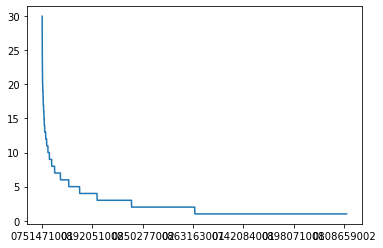

In [130]:
pd.value_counts(duplicated_purchases).plot()

A small subset of items are purchased frequently by the same customer, other items are not.

Let's be quite conservative here and show our prospective buyers only items that have been purchased mutliple times by someone at least on 5 occasions.

In [209]:
duplicate_recs_ok = set(pd.value_counts(duplicated_purchases)[pd.value_counts(duplicated_purchases) > 5].index.tolist())
len(duplicate_recs_ok)

528

In [188]:
%%time

already_bought_by_cust = {}
for grp in transactions_min.groupby('customer_id'):
    already_bought_by_cust[grp[1]['customer_id'].iloc[0]] = set(grp[1]['article_id'])

CPU times: user 2.57 s, sys: 29.8 ms, total: 2.6 s
Wall time: 2.6 s


Let us now calculate the new submission and evaluate it on our validation set!

In [472]:
earlier_sub = pd.read_csv('data/subs/most_purchased_last_two_weeks.csv.gz')
preds = earlier_sub['prediction'].str.split().values

calculate_apk(earlier_sub['prediction'].str.split(), validation_set.purchases)

0.0036434351466822766

Now what will the score be if we leverage our product-customer affinity matrix?

In [214]:
%%time

new_preds_by_cust = {}

for i in range(art_by_cust_score.shape[1]):
    ps = []
    sub_cust_id = cust_ids[mapped_custs[i]]
    for art_idx in art_by_cust_score[:, i].argsort(descending=True):
        sub_art_id = art_ids[mapped_arts[art_idx]]
        if (sub_art_id not in already_bought_by_cust[sub_cust_id]) or (sub_art_id in duplicate_recs_ok):
            ps.append(sub_art_id)
        if len(ps) > 12: break
    new_preds_by_cust[sub_cust_id] = ps

CPU times: user 2h 54min 58s, sys: 2min 4s, total: 2h 57min 2s
Wall time: 31min 45s


In [216]:
# pd.to_pickle(new_preds_by_cust, 'data/new_preds_by_cust.pkl')

In [473]:
validation_set_cust_id2idx = {customer_id: i for i, customer_id in enumerate(validation_set.customer_id.values)}

In [474]:
for cust_id, ps in new_preds_by_cust.items():
    if cust_id in validation_set_cust_id2idx.keys():
        validation_idx = validation_set_cust_id2idx[cust_id]
        preds[validation_idx] = ps

The big moment... will our tweaked predictions do better?

In [475]:
calculate_apk(preds, validation_set.purchases)

0.003543575321813754

We seem to be doing worse.

At this point, it is really hard to say what might be going on.

Could there be a bug somewhere as I am going back and forth mapping between ids? Absolutely. Could there be a bug somewhere else? Of course.

It might also be very likely that the current approach just doesn't work, that this type of model trained just on frequent buyers is not very helpful. Or maybe it should be trained for longer / with different lr schedule. It kept improving during training, so maybe there is value in training it a bit more.

But at this point this is not really important. I only wanted to get my feet wet with the problem, to start to understand what might go into building a RecSys model, or better yet, system.

As such, let me do the two things that make sense here.

1. Let me look at recent repeat purchases. This notebook on [Kaggle](https://www.kaggle.com/hengzheng/time-is-our-best-friend-v2/notebook) seems to suggest that there might be signal there.
2. Let me change how we are evaluating results on our validation set. As is, mapping from ids back and forth is untenable, it is simply too cumbersome and error prone. The process should be: (a) write a submission to disk (b) call a function on it that would evaluate it against our validation set.

### Recent repeat purchases

In [360]:
cust_purch_7_days = {}

for cust_id, df in transactions_min[transactions_min.t_dat > (transactions_min.t_dat.max() - datetime.timedelta(days=7))].groupby('customer_id'):
    cust_purch_7_days[cust_id] = df.article_id.values

In [322]:
cust_purch_7_days_7_days_earlier = {}

for cust_id, df in transactions_min[(transactions_min.t_dat < (transactions_min.t_dat.max() - datetime.timedelta(days=7))) & (transactions_min.t_dat > (transactions_min.t_dat.max() - datetime.timedelta(days=14)))].groupby('customer_id'):
    cust_purch_7_days_7_days_earlier[cust_id] = df.article_id.values

In [328]:
len(set(cust_purch_7_days.keys()).intersection(set(cust_purch_7_days_7_days_earlier)))

1675

In [329]:
len(cust_purch_7_days), len(cust_purch_7_days_7_days_earlier)

(3874, 3518)

Wow, so many repeat customers week to week! Are they buying the same things?

In [330]:
repeat_purchases = 0
total_purchases = 0

for repeat_cust in set(cust_purch_7_days.keys()).intersection(set(cust_purch_7_days_7_days_earlier)):
    for purch in cust_purch_7_days[repeat_cust]:
        total_purchases += 1
        if purch in cust_purch_7_days_7_days_earlier[repeat_cust]:
            repeat_purchases +=1            

In [332]:
repeat_purchases, total_purchases

(562, 9982)

5% of items were rebought in a subsequent week. That is a lot. A good submission will likely need to somehow capture this tendency.

In [383]:
frequent_buyers = set(new_preds_by_cust.keys())

In [386]:
from collections import defaultdict

In [404]:
cust_purchases = defaultdict(list)

df = transactions_without_last_7_days[transactions_without_last_7_days.t_dat > (transactions_without_last_7_days.t_dat.max() - datetime.timedelta(days=7))]

for idx, (cust_id, art_id) in df[['customer_id', 'article_id']].iterrows():
    cust_purchases[cust_id].append(art_id)

In [484]:
earlier_sub = pd.read_csv('data/subs/most_purchased_last_two_weeks.csv.gz')
preds = earlier_sub['prediction'].str.split().values

In [485]:
for cust_id, purchases in cust_purchases.items():
    if cust_id in validation_set_cust_id2idx.keys():
        validation_idx = validation_set_cust_id2idx[cust_id]
        purchases = purchases[:12]
        preds[validation_idx][len(purchases):] = purchases

In [486]:
calculate_apk(preds, validation_set.purchases)

0.009425028566550515

Ok, this is significantly better. Apart from learning a bit more about the tendencies to expect in the dataset, this also tells me that my validation scheme could be okay-ish, there is some chance this part of the code works.

Let's refactor it so that we can use it to evaluate actual submissions.

In [489]:
sample_sub.shape

(1371980, 2)

In [499]:
preds =[]
c_ids_in_val = set(validation_set_cust_id2idx.keys())
for c_id in sample_sub.customer_id:
    if c_id in c_ids_in_val:
        preds.append(validation_set.purchases[validation_set_cust_id2idx[c_id]])
    else:
        preds.append(['0']*12)

In [512]:
preds_as_str = [' '.join(l) for l in preds]
validation_set = sample_sub.copy()
validation_set.prediction = preds_as_str

In [521]:
validation_set.to_csv('data/subs/validation_set.csv', index=False)

What could our evaluation code look like?

In [526]:

sub_to_eval_2 = pd.read_csv('data/subs/most_purchased_3_mths_ago_two_weeks.csv.gz')

In [573]:
def eval_sub(sub_csv, skip_cust_with_no_purchases=True):
    sub=pd.read_csv(sub_csv)
    validation_set=pd.read_csv('data/subs/validation_set.csv')

    apks = []
    
    no_purchases_pattern = ['0']*12
    for pred, gt in zip(sub.prediction.str.split(), validation_set.prediction.str.split()):
        if skip_cust_with_no_purchases & (gt == no_purchases_pattern): continue
        apks.append(apk(pred, gt))
    return np.mean(apks)

In [576]:
eval_sub('data/subs/most_purchased_last_two_weeks.csv.gz')

0.0036434351466822766

In [577]:
eval_sub('data/subs/most_purchased_last_two_weeks.csv.gz', skip_cust_with_no_purchases=False)

0.0001831941647536627

In [578]:
eval_sub('data/subs/most_purchased_3_mths_ago_two_weeks.csv.gz')

0.00044962634537753403